In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

    def __radd__(self, other): # other + self
        return self + other

    def __truediv__(self, other):
        return self * (other**-1)

    def __rmul__(self, other):  # other * self
        return self * other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

In [3]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
# basic nueral network

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [5]:
o.backward()

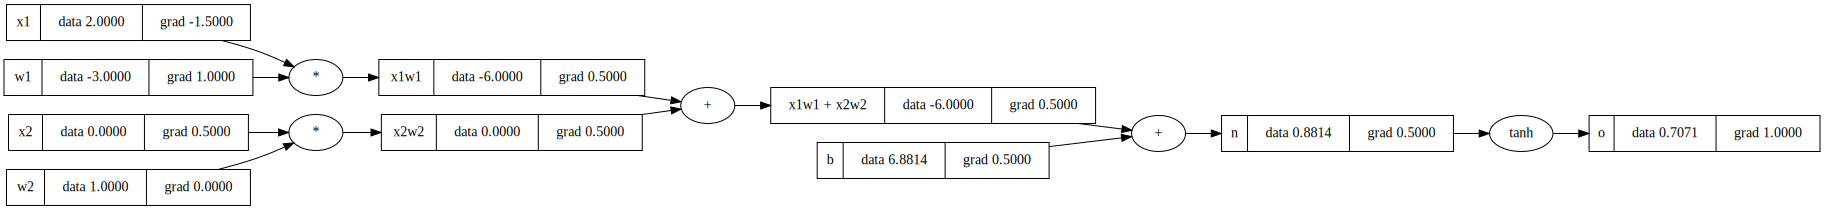

In [6]:
draw_dot(o)

In [7]:
# basic nueral network

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# ---------
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
# ---------


In [8]:
o.backward()

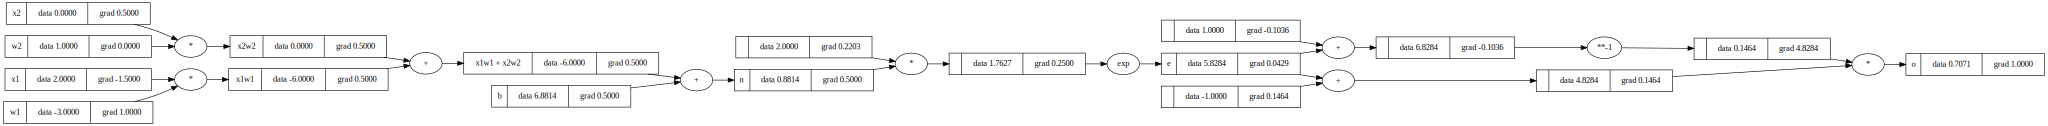

In [9]:
draw_dot(o)

## Implementing basic neural net with a backprop using pytorch

In [10]:
import torch

In [11]:
x1 = torch.Tensor([2.0]).double()               ;   x1.requires_grad = True 
x2 = torch.Tensor([0.0]).double()               ;   x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double()              ;   w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double()               ;   w2.requires_grad = True 
b = torch.Tensor([6.8813735870195432]).double() ;   b.requires_grad = True 
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('---')
print(f'x1: {x1.grad.item()}')
print(f'w1: {w1.grad.item()}')
print(f'x2: {x2.grad.item()}')
print(f'w2: {w2.grad.item()}')
print(f'b: {b.grad.item()}')

0.7071066904050358
---
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0
b: 0.5000001283844369


## Implementing a neural net with pytorch

In [32]:
import random


class Neuron:

    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin: int, nouts: list) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
# draw_dot(mlp(x))

In [33]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]     # desired targets
mlp = MLP(3, [4,4,1])
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.836930233562513),
 Value(data=0.6527762112414744),
 Value(data=0.6804228850494523),
 Value(data=0.929893530689189)]

In [34]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ypred)
loss

Value(data=1.396749235702213)

In [104]:
loss.backward()

In [105]:
for p in mlp.parameters():
    p.data += -0.01*p.grad

In [106]:
ypred = [mlp(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ypred)
loss

Value(data=0.002284167477904493)

In [107]:
ypred

[Value(data=0.9590754118918053),
 Value(data=-0.9975285532570205),
 Value(data=-0.9875499032429295),
 Value(data=0.9145556611499113)]

## Formalising the gradient descent

In [120]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]     # desired targets
mlp = MLP(3, [4,4,1])

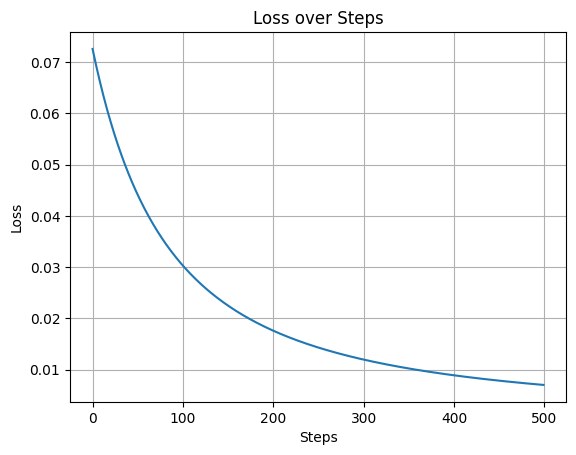

In [124]:
history = []
for k in range(500):
    # forward pass
    ypred = [mlp(x) for x in xs]

    # calculate loss
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)) / len(ypred)

    # backward pass loss
    for p in mlp.parameters():
        p.grad = 0
    loss.backward()

    # update weights
    for p in mlp.parameters():
        p.data += -0.01 * p.grad

    # print(k, loss.data)
    history.append((k, loss.data))


# Unzip history into steps and losses
steps, losses = zip(*history)

# Plotting
plt.plot(steps, losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.grid(True)
plt.show()

In [125]:
ypred

[Value(data=0.904365912140486),
 Value(data=-0.9512910225640893),
 Value(data=-0.8929707742757702),
 Value(data=0.9281189349872153)]